<a href="https://colab.research.google.com/github/glf58/Projet_Covid/blob/GLF/show_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import shutil
import datetime 
import tensorflow as tf

from google.colab import drive
from zipfile import ZipFile

from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
archive = '/content/drive/MyDrive/kaggle/covid19-radiography-database.zip'
with ZipFile(archive, 'r') as zip_ref:
  zip_ref.extractall('/content')

In [4]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/covid/modeles/saved_models/Lenet_orig')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 295, 295, 8)       208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 147, 147, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 145, 145, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 72, 72, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 70, 70, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 35, 35, 32)       0

(299, 299, 1) [1]


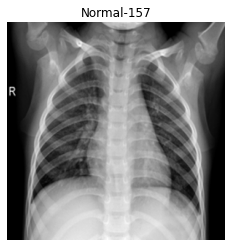

In [10]:
IMG_SIZE = 299
def load_and_preprocess(img_path, mask_path, y):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_png(img, channels=1)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE], method='nearest')
  
  #mask = tf.io.read_file(mask_path)
  #mask = tf.io.decode_png(mask, channels=1)
  #mask = tf.image.resize(mask, [IMG_SIZE, IMG_SIZE], method='nearest')
  #masked_img = tf.bitwise.bitwise_and(img, mask)
  masked_img = img
      
  return (tf.cast(masked_img, tf.float32)/225.0, y)

idx = 157
cat = 'Normal' #'COVID' 'Normal', ''Lung_Opacity', 'Viral Pneumonia'
img_path = '/content/COVID-19_Radiography_Dataset/'+cat+'/images/'+cat+'-'+str(idx)+'.png'
name_save = '/content/drive/MyDrive/Colab Notebooks/covid/results/'+cat+'-'+str(idx)
save = True

test = tf.data.Dataset.from_tensor_slices(([img_path], [img_path], [1]))
test = test.map(load_and_preprocess).batch(1)
img, y = next(iter(test))
print(img[0].shape, y.numpy())
plt.figure()
plt.imshow(np.squeeze(img[0].numpy(),-1), cmap='gray')
plt.axis('off')
plt.title(cat+'-'+str(idx))
if save:
  plt.savefig(name_save+'.png')

In [11]:
print(img.shape)
y_pred = model.predict(img)
y_pred

(1, 299, 299, 1)


array([[2.7377993e-07, 1.0742448e-09, 9.9614280e-01, 3.8570408e-03]],
      dtype=float32)

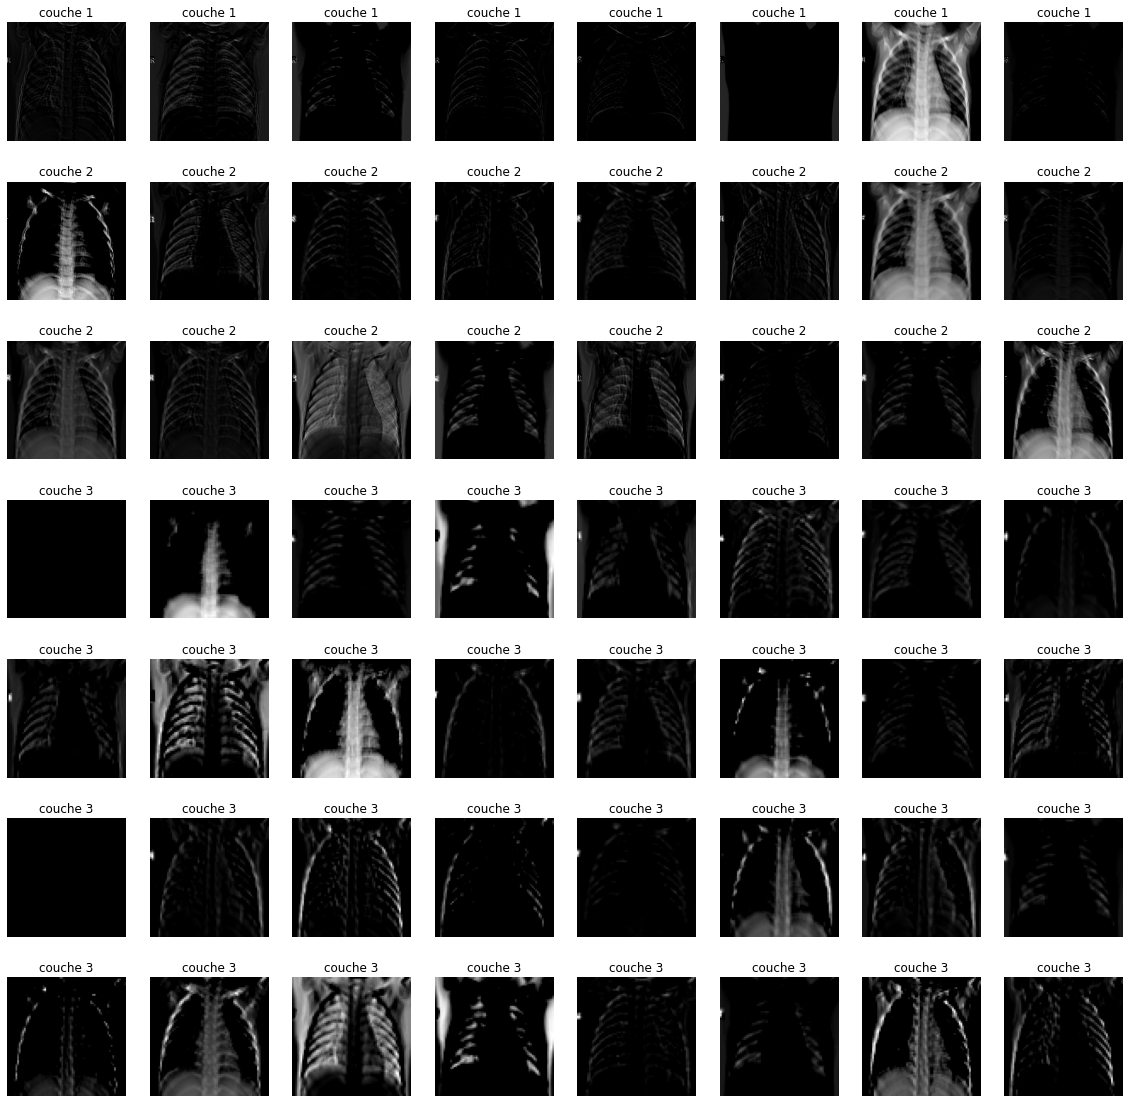

In [12]:
plt.figure(figsize=(20,20))
j = 0

new_model = Sequential(model.layers[:1])
new_model.compile(optimizer='adam', loss='sparse_categoricall_crossentropy')
res = new_model.predict(img)
n = res.shape[-1]
for i in range(n):
  plt.subplot(7,8,j+1)
  plt.imshow(res[0,:,:,i], cmap='gray')
  plt.title('couche 1')
  plt.axis('off')
  j += 1 

new_model = Sequential(model.layers[:3])
new_model.compile(optimizer='adam', loss='sparse_categoricall_crossentropy')
res2 = new_model.predict(img)
n = res2.shape[-1]
for i in range(n):
  plt.subplot(7,8,j+1)
  plt.imshow(res2[0,:,:,i], cmap='gray')
  plt.title('couche 2')
  plt.axis('off')
  j += 1

new_model = Sequential(model.layers[:5])
new_model.compile(optimizer='adam', loss='sparse_categoricall_crossentropy')
res3 = new_model.predict(img)
n = res3.shape[-1]
for i in range(n):
  plt.subplot(7,8,j+1)
  plt.imshow(res3[0,:,:,i], cmap='gray')
  plt.title('couche 3')
  plt.axis('off')
  j += 1
if save:
  plt.savefig(name_save+'all_features'+'.png')